# Introduction

# Loading Data

The dataset consists of detection *events*, wherein a variable number of particles come into contact with the detector's cells. The location of these impacts are called *hits*, and there are likewise a variable number of them per particle.

In [214]:
import pickle
import numpy as np

with open('tracks.pickle', 'rb') as f:
    samples = pickle.load(f)

print("Loaded {} samples.".format(len(samples)))

Loaded 100 samples.


### Features

Each sample contains a set of hits, and each hit contains the following information:

* *x,y,z* coordinates
* Cell count and impact magnitude
* A learned hit embedding, output from the previous graph creation stage
* Ground truth cluster ID, denoting the particle which created the hit

Additionally, samples contain graphs as output from the previous stage which aims to connect hits created by the same particle. The two graphs included are

* A predicted graph, the raw output from the graph building stage
* An augmented graph, which contains the predicted graph, plus any connections missed between hits created by the same particle. This is used in the GNN's loss function.

### Visualizations

Choosing a sample to explore, one can see how the embedding differs from the raw features for graph creation.

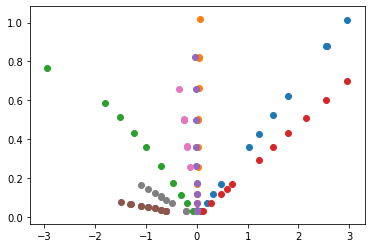

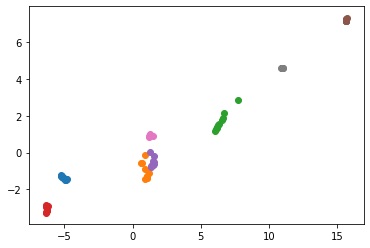

<Figure size 432x288 with 0 Axes>

In [215]:
import matplotlib.pyplot as plt

def plot_clusters(x,y,pid):
    for g in np.unique(pid):
        i = np.where(pid == g)
        plt.scatter(x[i],y[i], label=g)
    plt.show()
    plt.clf()

hits = samples[1]['hits']
xyz = hits['xyz']
emb = hits['emb']
pid = hits['particle_id']

# Hit coordinates
plot_clusters(xyz[:,2], np.sqrt(xyz[:,0]**2 + xyz[:,1]**2), pid)

# Emb coordinates
plot_clusters(emb[:,0], emb[:,1], pid)

Clearly, the embedding will lead to superior clustering as compared with the raw *x,y,z* positions. However, this embedding incorporates information from only each hit individually. With a GNN, one can create node embeddings which incorporate information from the hit's neighborhood. As we will see, this allows for superior embeddings and thus improved performance in clustering.

# Model

The GNN model chosen is a simple message-passing architecture. One layer concatenates each node's features with an aggregation of the node's neighborhood, before applying a transformation via a fully-connected neural network layer.

The output of the model is a set of node embeddings, where this new embedding has the same goal as in the graph building stage: according to some distance metric, node pairs whose hits belong to the same particle should be close, and otherwise they should be far.

In [216]:
import dgl
import torch
import torch.nn as nn

class GNN(nn.Module):
    def __init__(self,
                   nb_hidden_gnn,
                   nb_layer,
                   nb_hidden_kernel,
                   nb_kernel,
                   input_dim):
        super(GNN, self).__init__()

        # Construct first layer
        gnn_layers = [GNN_Layer(input_dim,
                                nb_hidden_gnn,
                                nb_kernel,
                                nb_hidden_kernel,
                                apply_norm=True,
                                softmax=False)]

        # Construct additional layers
        for _ in range(nb_layer-1):
            gnn_layers.append(GNN_Layer(nb_hidden_gnn,
                                        nb_hidden_gnn,
                                        nb_kernel,
                                        nb_hidden_kernel))
        self.layers = nn.ModuleList(gnn_layers)

        self.final_emb = nn.Linear(nb_hidden_gnn, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, g):
        if torch.cuda.is_available():
            g.ndata['feat'] = g.ndata.pop('feat').to('cuda', non_blocking=True)
        feat = g.ndata['feat']
        emb = g.ndata.pop('feat')
        for i, layer in enumerate(self.layers):
            emb = layer(g, emb)
        emb = self.sigmoid(self.final_emb(emb))
        g.ndata['feat'] = feat
        return emb.squeeze(1)

    def weighted_msg(e):
        return {'msg': e.src['feat'] * e.data['e']}


class GNN_Layer(nn.Module):
    def __init__(self,
               input_dim,
               nb_hidden_gnn,
               nb_kernel,
               nb_hidden_kernel,
               apply_norm=True,
               softmax=False):
        super(GNN_Layer, self).__init__()

        if softmax:
            self.kernel = MLP_Kernel_DGL_Softmax(input_dim, nb_hidden_kernel)
        else:
            self.kernel = MLP_Kernel_DGL(input_dim, nb_hidden_kernel)

        self.gconv = DGL_Convolution(input_dim, nb_hidden_gnn)
        self.bn = nn.BatchNorm1d(input_dim,momentum=0.10) if apply_norm else None

    def forward(self, g, features):
        # maybe apply normalization
        if self.bn is not None:
            features = self.bn(features)
        g.ndata['feat'] = features

        # set edge weights for this layer
        g = self.kernel(g)
        
        # send weighted messages and apply graph convolution to nodes
        g.send_and_recv(g.edges(),
                        message_func=weighted_msg,
                        reduce_func=dgl.function.sum(msg='msg', out='agg_msg'),
                        apply_node_func=self.gconv)
        g.ndata.pop('feat')
        g.ndata.pop('agg_msg')
        return g.ndata.pop('emb')

class DGL_Convolution(nn.Module):
    def __init__(self,
               input_dim,
               nb_hidden_gnn):
        super(DGL_Convolution, self).__init__()
        self.weights = nn.Linear(2*input_dim, nb_hidden_gnn)
        self.act = nn.ReLU()

    def forward(self, n):
        feats = n.data['feat']
        agg_msg = n.data['agg_msg']
        node_feats = torch.cat((feats, agg_msg), dim=1)
        emb = self.weights(node_feats)
        emb = self.act(emb)
        return {'emb':emb}


class MLP_Kernel_DGL(nn.Module):
    def __init__(self, nb_input, nb_hidden_gnn, nb_output=1, nb_layer=1):
        super(MLP_Kernel_DGL, self).__init__()
        layers = [nn.Linear(nb_input*2, nb_hidden_gnn)]
        for _ in range(nb_layer-1):
            layers.append(nn.Linear(nb_hidden_gnn, nb_hidden_gnn))
        layers.append(nn.Linear(nb_hidden_gnn, nb_output))
        self.layers = nn.ModuleList(layers)
        self.act1 = nn.ReLU()
        self.act2 = nn.Sigmoid()

    def forward(self, g):
        g.apply_edges(self.mlp)
        return g

    def mlp(self, e):
        # Gather features from all relevant node pairs
        src = e.src['feat']
        dst = e.dst['feat']
        e_feats = torch.cat((src,dst),dim=1)
        
        # Apply MLP layers to node pairs
        for l in self.layers[:-1]:
            e_feats = self.act1(l(e_feats))
        
        # Apply final output with sigmoid
        e_feats = self.layers[-1](e_feats)
        e_feats = self.act2(e_feats)
        return {'e':e_feats}

In [217]:
# Hierarchical clustering model

class Hier_GNN(nn.Module):
    def __init__(self, nb_input, nb_hidden, nb_layer):
        super(Hier_GNN, self).__init__()
        self.split_gnn = GNN(nb_hidden, nb_layers, nb_hidden, 1, nb_input)
        self.stop_gnn  = GNN(nb_hidden, nb_layers, nb_hidden, 1, nb_input)
    
    # Training
    def forward(self, g_input, truth, depth):
        stop_graph, stop_loss = self.stop(g_input, truth[depth])
        if stop_graph is None:
            return 0, stop_loss
        split_graph, split_loss = self.split(stop_graph, truth[depth])
        
        stop_loss_rec, split_loss_rec = self(split_graph, truth, depth+1)
        return stop_loss + stop_loss_rec, split_loss + split_loss_rec
    
    def stop(self, g_input, truth):
        assert torch.equal(g_input.ndata['hit_id'], torch.LongTensor(truth[0]))
        stop_pred = self.stop_gnn(g_input)
        stop_truth = torch.FloatTensor(truth[2])
        stop_loss = nn.functional.binary_cross_entropy(stop_pred, stop_truth)
        if sum(stop_truth) < 1:
            return g_input, stop_loss
        elif int(sum(stop_truth)) == len(stop_truth):
            return None, stop_loss
        
        g_input.ndata['stop'] = stop_truth
        should_stop = list(dgl.mean_nodes(g_input, 'stop').numpy())
        
        g = dgl.unbatch(g_input)
        keep = []
        for i, gt in enumerate(should_stop):
            if gt < 0.5:
                keep.append(g[i])
        g = dgl.batch(keep)
        return g, stop_loss
    
    def split(self, g_input, truth):
        where_keep = (1-truth[2]).astype(bool)
        hit_ids = truth[0][where_keep]
        assert torch.equal(g_input.ndata['hit_id'], torch.LongTensor(hit_ids))
        split_pred = self.split_gnn(g_input)
        split_truth = torch.FloatTensor(truth[1][where_keep])
        split_loss_a = nn.functional.binary_cross_entropy(split_pred, split_truth, reduction='none')
        split_loss_b = nn.functional.binary_cross_entropy(split_pred, 1-split_truth, reduction='none')
        
        # Loss should respect divide, not direction
        g_input.ndata['loss_a'] = split_loss_a
        g_input.ndata['loss_b'] = split_loss_b
        loss_a = dgl.mean_nodes(g_input, 'loss_a')
        loss_b = dgl.mean_nodes(g_input, 'loss_b')
        split_loss = torch.min(loss_a, loss_b).mean()
        
        g_input.ndata['split'] = split_truth
        graphs = dgl.unbatch(g_input)
        new_graphs = []
        for g in graphs:
            g_l, g_r = self.split_one_graph(g)
            new_graphs += [g_l, g_r]
        split_graph = dgl.batch(new_graphs)
        return split_graph, split_loss
    
    def split_one_graph(self, g):
        truth = g.ndata['split']
        go_left = (truth==0).nonzero().squeeze(1)
        go_right = truth.nonzero().squeeze(1)
        g_l = g.subgraph(list(go_left.numpy()))
        g_r = g.subgraph(list(go_right.numpy()))
        g_l.copy_from_parent()
        g_r.copy_from_parent()
        if len(go_left) == 0:
            g_l = None
        if len(go_right) == 0:
            g_r = None
        return g_l, g_r
    
    
    # Inference
    def build_clusters(self, g_input, depth, max_depth):
        print('\n',depth)
        if depth == 0:
            self.next_cluster = 0
            self.clusters = []
        if depth == max_depth:
            hit_ids = g_input.ndata['hit_id']
            clusters = np.array([self.next_cluster]*len(hit_ids))
            self.clusters.append((hit_ids.numpy(), clusters))
            return self.organize_clusters(self.clusters)
        g = self.stop_inference(g_input)
        if g is None:
            return self.organize_clusters(self.clusters)
        else:
            g = self.split_inference(g_input)
            return self.build_clusters(g, depth+1, max_depth)
        
    def stop_inference(self, g_input):
        stop_pred = self.stop_gnn(g_input)
        
        g_input.ndata['stop'] = stop_pred
        should_stop = list(dgl.mean_nodes(g_input, 'stop').numpy())
        print("should stop", should_stop)
        
        g = dgl.unbatch(g_input)
        keep = []
        stop = []
        for i, gt in enumerate(should_stop):
            if gt < 0.5:
                keep.append(g[i])
            else:
                stop.append(g[i])
        
        if len(stop)==0:
            return g_input
        
        # Assign cluster labels
        for stopped in stop:
            hit_ids = stopped.ndata['hit_id']
            clusters = np.array([self.next_cluster]*len(hit_ids))
            self.clusters.append((hit_ids.numpy(), clusters))
            self.next_cluster += 1
        
        if len(keep) == 0:
            return None
        else:
            g = dgl.batch(keep)
            return g
        
    def split_inference(self, g_input):
        split_pred = self.split_gnn(g_input)

        g_input.ndata['split'] = split_pred.round().to(torch.long)
        graphs = dgl.unbatch(g_input)
        new_graphs = []
        for g in graphs:
            g_l, g_r = self.split_one_graph(g)
            if g_l is not None:
                new_graphs.append(g_l)
            if g_r is not None:
                new_graphs.append(g_r)
        split_graph = dgl.batch(new_graphs)
        return split_graph
    
    def organize_clusters(self, clusters):
        hit_ids = [c[0] for c in clusters]
        cluster_ids = [c[1] for c in clusters]
        
        hit_ids = np.concatenate(hit_ids)
        cluster_ids = np.concatenate(cluster_ids)
        
        return cluster_ids[np.argsort(hit_ids)]

# Dataset, Dataloader

In [218]:
from torch.utils.data import Dataset

def get_edge_indices(edges):
    edge_pairs = []
    for i, neighbors in enumerate(edges):
        for e_idx in neighbors:
            edge_pairs.append([i,e_idx])
    return edge_pairs

def get_true_edge_values(pred_edge_idx, true_edges):
    values = [0] * len(pred_edge_idx)
    for i, (src, dst) in enumerate(pred_edge_idx):
        if dst in true_edges[src]:
            values[i] = 1
    return values

class TrackML_Dataset(Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __getitem__(self, index):
        s = self.samples[index]
        
        hits = s['hits']
        xyz  = hits['xyz']
        emb  = hits['emb']
        pid  = torch.FloatTensor(hits['particle_id'])
        weight  = torch.FloatTensor(hits['weight'])
        hits = torch.FloatTensor(np.concatenate((xyz, emb), axis=1))
        

        graphs = s['graphs']
        pred_edges = graphs['pred']
        loss_edges = graphs['loss']
        true_edges = graphs['true']
    
        pred_edge_idx = get_edge_indices(pred_edges)
        
        # Build inference graph
        g_input = dgl.DGLGraph()
        g_input.add_nodes(len(hits))
        src, dst = tuple(zip(*pred_edge_idx))
        g_input.add_edges(src, dst)
        g_input.ndata['feat'] = hits
        g_input.ndata['pid'] = pid
        g_input.ndata['weight'] = weight

        g_input.set_n_initializer(dgl.init.zero_initializer)
        g_input.set_e_initializer(dgl.init.zero_initializer)

        # Get hierarchy data
        hier = s['hier']
        g_input.ndata['hit_id'] = torch.LongTensor(hier[0][0])

        return g_input, hier
    
    def __len__(self):
        return len(self.samples)
    
def trackml_collate(sample):
    g_input = [s[0] for s in sample]
    g_input = dgl.batch(g_input)
    
    hier   = [s[1] for s in sample]
    assert(len(hier) == 1)

    return g_input, hier[0]

# Training

## Setup

In [219]:
import torch.nn.functional as F
from torch.utils.data import DataLoader

# PARAMETERS
batch_size = 1
nb_hidden = 32
nb_layers = 3
learn_rate = 0.001

dataset = TrackML_Dataset(samples)
dataloader = DataLoader(dataset, 
                        batch_size=batch_size, 
                        collate_fn=trackml_collate, 
                        drop_last=True, 
                        shuffle=True,
                        num_workers=0)

net = Hier_GNN(6, nb_hidden, nb_layers)
optim = torch.optim.Adamax(net.parameters(), lr=learn_rate)
# print(net)

In [ ]:
def get_emb_for_loss(e):
    src = e.src['emb']
    dst = e.dst['emb']
    truth = e.data['truth']
    pred_dst = nn.functional.pairwise_distance(src, dst)
    true_dst = truth*2 -1
    loss = nn.functional.hinge_embedding_loss(pred_dst, true_dst, reduction='none')
    return {'loss':loss, 'pred_dst':pred_dst, 'true_dst':true_dst}

def score_dist_accuracy(pred, true):
    pred = pred.round()
    pred[pred!=0] = 1
    pred = 1-pred
    correct = pred==true
    nb_correct = correct.sum()
    nb_total = true.size(0)
    score = float(nb_correct.item()) / nb_total
    return score

def train_one_epoch(net, batch_size, optimizer, train_loader):
    net.train()

    nb_batch = len(train_loader)
    nb_train = nb_batch * batch_size
    epoch_score = 0
    epoch_loss  = 0
    epoch_split = 0
    epoch_stop  = 0

    print("\nTraining on {} samples".format(nb_train))
    for i, (g_input, hier) in enumerate(train_loader):
        optimizer.zero_grad()
        
        f = g_input.ndata['feat']

        stop_loss, split_loss = net(g_input, hier, 0)

        loss = stop_loss + split_loss
        score = 0

        loss.backward()
        optimizer.step()

        epoch_score += score * 100
        epoch_loss  += loss.item()
        epoch_split += split_loss.item()
        epoch_stop  += stop_loss.item()

        nb_proc = (i+1) * batch_size
        if (((i) % (nb_batch//5)) == 0):
            print("  {:3d}  Loss: {:.2f}  Split: {:1.2f}  Stop: {:1.2f}".format(
                                nb_proc, epoch_loss/(i+1), epoch_split/(i+1), epoch_stop/(i+1)))
    return epoch_loss / nb_batch, epoch_score / nb_batch

for i in range(4):
    train_one_epoch(net, batch_size, optim, dataloader)


Training on 100 samples
    1  Loss: 6.67  Split: 3.78  Stop: 2.90
   21  Loss: 6.56  Split: 3.85  Stop: 2.72
   41  Loss: 6.43  Split: 3.83  Stop: 2.60


# Clustering

In [ ]:
# Embed samples
clusters = []
pid = []
weight = []
net.eval()
with torch.autograd.no_grad():
    for i, (g_input, hier) in enumerate(dataloader):
        pid.append(g_input.ndata['pid'])
        weight.append(g_input.ndata['weight'])
        c = net.build_clusters(g_input, 0, max_depth=10)
        clusters.append(c)
        break

In [ ]:
# Score samples


"""
TrackML scoring metric (by Sabrina Amrouche, David Rousseau, Moritz Kiehn, Ilija Vukotic)
"""

import numpy
import pandas

def _analyze_tracks(truth, submission):
    particles_nhits = truth['particle_id'].value_counts(sort=False)
    total_weight = truth['weight'].sum()
    event = pandas.merge(truth[['hit_id', 'particle_id', 'weight']],
                         submission[['hit_id', 'track_id']],
                         on=['hit_id'], how='left', validate='one_to_one')
    event.drop('hit_id', axis=1, inplace=True)
    event.sort_values(by=['track_id', 'particle_id'], inplace=True)


    tracks = []
    rec_track_id = -1
    rec_nhits = 0
    cur_particle_id = -1
    cur_nhits = 0
    cur_weight = 0
    maj_particle_id = -1
    maj_nhits = 0
    maj_weight = 0

    for hit in event.itertuples(index=False):
        if (rec_track_id != -1) and (rec_track_id != hit.track_id):
            if maj_nhits < cur_nhits:
                maj_particle_id = cur_particle_id
                maj_nhits = cur_nhits
                maj_weight = cur_weight
            tracks.append((rec_track_id, rec_nhits, maj_particle_id,
                particles_nhits[maj_particle_id], maj_nhits,
                maj_weight / total_weight))

        if rec_track_id != hit.track_id:
            rec_track_id = hit.track_id
            rec_nhits = 1
            cur_particle_id = hit.particle_id
            cur_nhits = 1
            cur_weight = hit.weight
            maj_particle_id = -1
            maj_nhits = 0
            maj_weights = 0
            continue

        rec_nhits += 1

        if cur_particle_id != hit.particle_id:
            if maj_nhits < cur_nhits:
                maj_particle_id = cur_particle_id
                maj_nhits = cur_nhits
                maj_weight = cur_weight
            cur_particle_id = hit.particle_id
            cur_nhits = 1
            cur_weight = hit.weight
        else:
            cur_nhits += 1
            cur_weight += hit.weight

    if maj_nhits < cur_nhits:
        maj_particle_id = cur_particle_id
        maj_nhits = cur_nhits
        maj_weight = cur_weight
    tracks.append((rec_track_id, rec_nhits, maj_particle_id,
        particles_nhits[maj_particle_id], maj_nhits, maj_weight / total_weight))

    cols = ['track_id', 'nhits',
            'major_particle_id', 'major_particle_nhits',
            'major_nhits', 'major_weight']
    return pandas.DataFrame.from_records(tracks, columns=cols)

def score_event(truth, submission):
    tracks = _analyze_tracks(truth, submission)
    purity_rec = np.true_divide(tracks['major_nhits'], tracks['nhits'])
    purity_maj = np.true_divide(tracks['major_nhits'], tracks['major_particle_nhits'])
    good_track = (0.5 < purity_rec) & (0.5 < purity_maj)
    return tracks['major_weight'][good_track].sum()


In [ ]:
### Get final cluster scores

avg_score = 0.0
nb_samples = 20
for i in range(nb_samples):
    cl = clusters[0]
    print(cl)
    hit_ids = np.arange(len(cl))
    truth = pandas.DataFrame.from_dict({'particle_id':pid[i].numpy(),
                                        'hit_id':hit_ids,
                                        'weight':weight[i].numpy()})
    submission = pandas.DataFrame.from_dict({'hit_id':hit_ids,
                                             'track_id':cl})
    score = score_event(truth, submission)
    avg_score += score
    break
print("TrackML score: {:.2f}".format(avg_score / nb_samples))